In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("proj03.ipynb")

<table style="width: 100%;" id="nb-header>">
        <tr style="background-color: transparent;"><td>
            <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
        </td><td>
            <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2024<br>
                Dr. Eric Van Dusen<br>
            Chris Pyles</p></td></tr>
    </table>

<!-- BEGIN QUESTION -->

# Project 3: Game Theory and Behavioral Economics

<!-- END QUESTION -->

In this notebook, we will introduce a fundamental thought experiment in the economics and statistics subdomain of **game theory**, called the Prisoner's Dilemma. We will then extend our consideration of game theory and behavioral economics to look at a recent paper that explores a phenomenon at the intersection of these topics.

At the end of this project, you should:
1. Understand the prisoner's dilemma and strategies for playing the game
3. Understand the game theory underpinnings of the Thomas and Pemstein (2015) paper
4. Be able to rerun the analysis in the aforementioned paper using hypothesis testing

In [3]:
from datascience import *
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = [25,10]
from players import *
import warnings
warnings.simplefilter('ignore')

## Part 1: The Iterated Prisoner's Dilemma

The [prisoner's dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) is a classic game first discussed by Merrill Flood and Melvin Dresher in 1950. In this game, there are two prisoners who have been captured and are being interrogated. The prisoners cannot contact each other in any way. They have two options: they can **defect** (betray the other prisoner to the police) or they can **cooperate** (maintain their silence). If both defect, both receive 4 years in prison. If one defects and the other does not, the defector goes free and the cooperator receives 5 years in prison. If both cooperate (meaning neither talks to the police), then they each receive 2 years in prison. We define **mutual defection** as the case when both prisoners defect and **mutual cooperation** as the case when both cooperate. The purpose of this game is to consider how a completely rational person would be best advised to proceed, and how different strategies for playing this game can be more or less effective.

<table>
    
<tr style="background-color: white;"><td></td><td></td><td colspan="2">Prisoner A</td></tr>
<tr><td></td><td></td><td>Cooperate</td><td>Defect</td></tr>
<tr style="background-color: white;"><td rowspan="2">Prisoner B</td><td>Cooperate</td><td style="background-color: #F5F5F5;">A: 2, B: 2</td><td>A: 0, B: 5</td></tr>
<tr><td>Defect</td><td>A: 5, B: 0</td><td style="background-color: #F5F5F5;">A: 4, B: 4</td></tr>
    
</table>

In this project, we will study the **iterated prisoner's dilemma**, a game paradigm in which the prisoner's dilemma is played over multiple rounds and in tournaments to determine the best strategy for playing the game. In this way, we define strategies as methods for determining whether a play will cooperate or defect at any single round based on this history of past moves. This differs from the normal prisoner's dilemma in that we play the game multiple times and incorporate strategies going beyond any single iteration.

This paradigm was introduced by [Robert Axelrod](https://en.wikipedia.org/wiki/Robert_Axelrod) to use the prisoner's dilemma as a lens through which to study the Cold War during the Cuban Missile Crisis. Axelrod created a tournament out of an iterated prisoner's dilemma and invited theoreticians to write programs that could strategically play the game, and then pitted them one against another in a round-robin-style tournament.

<!-- BEGIN QUESTION -->

**Question 1.1:** In the context of price wars, which prisoner's dilemma outcome is best for consumers? Why?


In the context of price wars, mutual defection (both firms lower prices) is the best outcome of consumers as it drives price down due to competition. Then both companies are trying to go to the lowest prices to undercut each other then the consumers will just buy them at the lowest price. 

<!-- END QUESTION -->

In this project, we will be creating some custom Python classes to represent different playing strategies. We'll be using the `create_player_class` function (provided) to create these classes for us. Here are a few important things to know about the classes:

Consider a player class instance `player = Player()`. 
* `player.play()` is a method that represents a single move. It returns `True` if the player **defects** and `False` if they cooperate.
* `player.history` is an array of the previous moves of the player instance. `player.history.item(-1)`, for example, is the most recent move (the last element of the array).

Don't worry about the other methods that are defined for players; these are there for the code below to work but you don't need to concern yourself with them. Here's how the `create_player_class` function works:

1. Define a function, `f`, that takes two arguments: `self` and `opponent` (more about these later), and returns `True` if the player defects and `False` otherwise.
2. Call `create_player_class` with two arguments: a string for the class name, e.g. `"Player"`, and the play method `f`.

Let's illustrate this by creating `Defector`, a player that always defects. The `defector_play` function below always returns `True`, since the player always defects. We then create `Defector` using `create_player_class`.

In [4]:
def defector_play(self, opponent):
    return True

Defector = create_player_class("Defector", defector_play)

Just like any class, we create a `Defector` instance by calling the constructor:

In [5]:
Defector()

Defector

**Question 1.2:** Create a `Cooperator` class that always cooperates.


In [6]:
def cooperator_play(self, opponent):
    return False

Cooperator = create_player_class("Cooperator", cooperator_play)

In [7]:
grader.check("q1_2")

q1_2 results: All test cases passed!

Now that we have players, how do we pit them against each other? Provided is a function called `payoff` that returns the values from our payoff matrix when provided two players by using their `play` methods. `payoff` returns a tuple of 2 elements corresponding to the payoff for the first and second player:

```python
>>> payoff(player_1, player_2)
(player 1 payoff, player 2 payoff)
```

In [8]:
payoff(Defector(), Cooperator())

(0, 5)

Our analysis of the prisoner's dilemma hinges on analyzing strategies over multiple rounds. For this reason, we need a way to pit players against each other and find out who has the fewest years accrued. The function `run_match` below will run a match of two players with `n` turns. If `winner` is `True`, it returns the winner of the match; if `winner` is `False`, it returns a list for each player containing the sequence of years accrued. Also note the first two lines of the function that reset the player history for each player. This is important because we might end up reusing instances of players, and we don't want histories from past matches to affect the results of this match.

In [9]:
def run_match(p1, p2, n=5, winner=True):
    p1.reset_history()
    p2.reset_history()
    
    p1_years = make_array()
    p2_years = make_array()
    
    for i in range(n):
        p1_score, p2_score = payoff(p1, p2)
        p1_years = np.append(p1_years, p1_score)
        p2_years = np.append(p2_years, p2_score)
        
    if winner:
        p1_mean = np.mean(p1_years)
        p2_mean = np.mean(p2_years)

        if p1_mean < p2_mean:
            return p1
        else:
            return p2
    else:
        return p1_years, p2_years

For example, we can run a 10-turn match between a defector and cooperator with:

In [10]:
run_match(Defector(), Cooperator(), n=10)

Defector

We see that the defector won the match, as expected. We can get the raw data (the number of years accrued by each player at each iteration) by setting `winner=False`:

In [11]:
run_match(Defector(), Cooperator(), n=10, winner=False)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.]))

Now that we know how to run matches, let's think of some other cool strategies. Remember the `player.history` variable discussed earlier? Let's have a concrete example on how to use that. The `Alternator` player defined below alternates between cooperating and defecting, beginning with cooperating.

Note the `if` statement. We need to check that we have a history to index into before we try to grab the last element; if we didn't have that statement, the code would fail on the first time  `Alternator` played, because we would try to get an element from an array with 0 elements.

In [12]:
def alternator_play(self, opponent):
    if len(self.history) > 0:
        return not self.history.item(-1)
    else:
        return False
    
Alternator = create_player_class("Alternator", alternator_play)

run_match(Alternator(), Defector())

Defector

**Question 1.3:** Use the player history to define `TitForTat`, a player that does the last thing it's opponent did and starts off by cooperating. For example, if we pitted `TitForTat` against a `Defector` in a 5-round match, the `Defector`'s moves would be `[D, D, D, D, D]`, and `TitForTat`'s would be `[C, D, D, D, D]`.


In [13]:
def tit_for_tat_play(self, opponent):
    if len(opponent.history) > 0:
        return opponent.history.item(-1)
    else:
        return False

TitForTat = create_player_class("TitForTat", tit_for_tat_play)

In [14]:
grader.check("q1_3")

q1_3 results: All test cases passed!

Now that we can pit two players against each other, how do we compare multiple players? We can create a tournament that runs matches between each pair of players.

<!-- BEGIN QUESTION -->

**Question 1.4:** In a tournament with $n$ players, how many matches are run?

_Hint:_ At an iteration $i$, how many players does player $i$ play against? Do you repeat any matches?


We would expect $\frac{n(n-1)}{2}$ matches to be run. Since the nth player can't play himself, he would play $n-1$ amount of opponents. We can simply multiply them. Since order doesn't matter (player 1 plays player 2 is the same as player 2 playing player 1), we can divide by 2 to eliminate the duplicates. 

<!-- END QUESTION -->

To run through the tournament, we'll need to iterate through each player and pit them against every other player in a match. To ensure that we don't duplicate matches, we'll loop from 0 to the number of players in the outer loop and loop from the next player to the last player in the inner loop. The function `most_common` returns the value in an array of values that has the largest number of occurrences; it is here used to determine which player won the most times.

In [15]:
players = make_array(Defector(), Cooperator())
winners = make_array()
for i in range(len(players)):
    for j in range(i+1, len(players)):
        winner = run_match(players.item(i), players.item(j))
        winners = np.append(winners, winner)
        
biggest_winner = most_common(winners)
biggest_winner

Defector

<!-- BEGIN QUESTION -->

**Question 1.5:** Consider the four strategies we've defined so far: defector, cooperator, alternator, and tit-for-tat. Which strategy do you think would win in a tournament between these four? Why?


Tit-for-Tat would probably win in a tournament between these four since it is a balance between cooperation and retaliation as it starts by cooperation and then recipricotes the opponents last action. So then it would exploit the cooperative opponents and be able to defend from defectors so it is a resilient strategy. 

<!-- END QUESTION -->

All of the strategies described in the table below, excepted `TitForTat` and `ForgivingTitForTat`, are provided.

| Name | Description |
|-----|-----|
| `Alternator` | Alternates between C and D |
| `Backstabber` | Forgives first 3 opponent D's then D forever after fourth |
| `Bully` | Starts by defecting and then does the opposite of opponent's previous move |
| `Desperate` | Only cooperates after mutual defection |
| `FoolMeOnce` | Forgives one D then retaliates forever on a second D |
| `Forgiver` | Starts by cooperating however will defect if at any point the opponent has defected more than 10 percent of the time |
| `ForgivingTitForTat` | Starts by cooperating and defects if opponent has defected more than 10% of the time **and** their last move was defection |
| `Grudger` | Starts with C and then D forever on opponent's first D |
| `OnceBitten` | C once on opponent D, but if opponent D's twice in a row defaults to D for 10 turns |
| `TitForTat` | Repeats opponent's previous move |

**Question 1.6:** Suppose we have a 10-turn match with a backstabber and a desperate. Write down the sequence of defections (D) and cooperations (C) for each player. Who wins the match?


In [16]:
backstabber_moves = make_array("C", "C", "C", "D", "D", "D", "D", "D", "D", "D")
desperate_moves = make_array("D", "D", "D", "D", "C", "C", "C", "C", "C", "C")
backstabber_desperate_winner = "Backstabber"

In [17]:
grader.check("q1_6")

q1_6 results: All test cases passed!

**Question 1.7:** Implement the player `ForgivingTitForTat` as described in the table above. The percentage should be calculated at each turn, so that if the opponent defects to above 10% and then lowers their defection percentage below 10% the `ForgivingTitForTat` player should cooperate.

_Hint:_ You can get the number of defections in a player's history by summing it or using `np.count_nonzero`, as defections are recorded as `True`.


In [18]:
def forgiving_tit_for_tat_play(self, opponent):
    if len(self.history) == 0:
        return False
    return np.count_nonzero(opponent.history) / len(opponent.history) and opponent.history.item(-1)
    
ForgivingTitForTat = create_player_class("ForgivingTitForTat", forgiving_tit_for_tat_play)

In [19]:
grader.check("q1_7")

q1_7 results: All test cases passed!

### Tournaments

Now that we have re-familiarized ourselves with our prisoner's dilemma code from the lab, let's move on to recreating Axelrod's tournament. Recall that Axelrod originally wanted to compare strategies for playing the prisoner's dilemma, which he did by pitting every strategy against every other strategy in a round-robin tournament. In this project, we will do the same thing, albeit on a much smaller scale, with the strategies defined in the table above.

**Question 1.8:** Fill in the function `run_tournament` below that takes in an array of players and returns a table with four columns: `p1`, `p1_mean`, `p2`, and `p2_mean`. As in Axelrod's original tournament, use matches with 200 rounds.

_Hint:_ Recall how we can use the `winner` argument of `run_match`.


In [20]:
def run_tournament(players):
    p1 = make_array() #This stores an array of all player 1's.
    p2 = make_array() #This stores an array of all player 2's.
    p1_means = make_array() #This stores an array of each player 1's average jail time for a particular game.
    p2_means = make_array() #This stores an array of each player 2's average jail time for a particular game.

    for i in range(len(players)):
        for j in range(i+1, len(players)):
            p1_years, p2_years = run_match(players.item(i), players.item(j), n=200, winner=False)
            p1 = np.append(p1, players.item(i))
            p2 = np.append(p2, players.item(j))
            p1_means = np.append(p1_means, np.mean(p1_years))
            p2_means = np.append(p2_means, np.mean(p2_years))
            
    results = Table().with_columns(
        "p1", p1,
        "p1_mean", p1_means,
        "p2", p2,
        "p2_mean", p2_means
    )

    return results

run_tournament(make_array(Defector(), Cooperator()))

p1,p1_mean,p2,p2_mean
Defector,0,Cooperator,5


In [21]:
grader.check("q1_8")

q1_8 results: All test cases passed!

**Question 1.9:** Create a tournament with all players in the table above Question 1.6. Assign the results table to `tournament_results`.


In [22]:
all_strategies = make_array(Alternator(), Backstabber(), Bully(), Desperate(), FoolMeOnce(), Forgiver(), ForgivingTitForTat(), Grudger(), OnceBitten(), TitForTat())
tournament_results = run_tournament(all_strategies)
tournament_results

p1,p1_mean,p2,p2_mean
Alternator,4.36,Backstabber,2.06
Alternator,3.015,Bully,2.99
Alternator,1.035,Desperate,3.485
Alternator,4.43,FoolMeOnce,2.03
Alternator,4.465,Forgiver,2.015
Alternator,2.485,ForgivingTitForTat,2.51
Alternator,4.465,Grudger,2.015
Alternator,1,OnceBitten,3.5
Alternator,2.485,TitForTat,2.51
Backstabber,0.12,Bully,4.895


In [23]:
grader.check("q1_9")

q1_9 results: All test cases passed!

To visualize our results, we will make a [heat map](https://en.wikipedia.org/wiki/Heat_map) that displays our results in an easy-to-read manner. The code in the cell below uses seaborn and pandas, two libraries you will learn about in Data 100, so don't worry about understanding it.

The plot shows Player 1 on the horizontal axis, Player 2 on the vertical axis, and the values in the cells are **Player 1's mean score** (i.e. the mean score of the player on the horizontal axis). So, if we look at the intersection of `OnceBitten` on the horizontal and `Forgiver` on the vertical, we see `OnceBitten`'s mean of 2.000 and if we do the reverse (`Forgiver` on horizontal, `OnceBitten` on vertical), we see `Forigiver`'s mean of 2.000.

<!-- BEGIN QUESTION -->

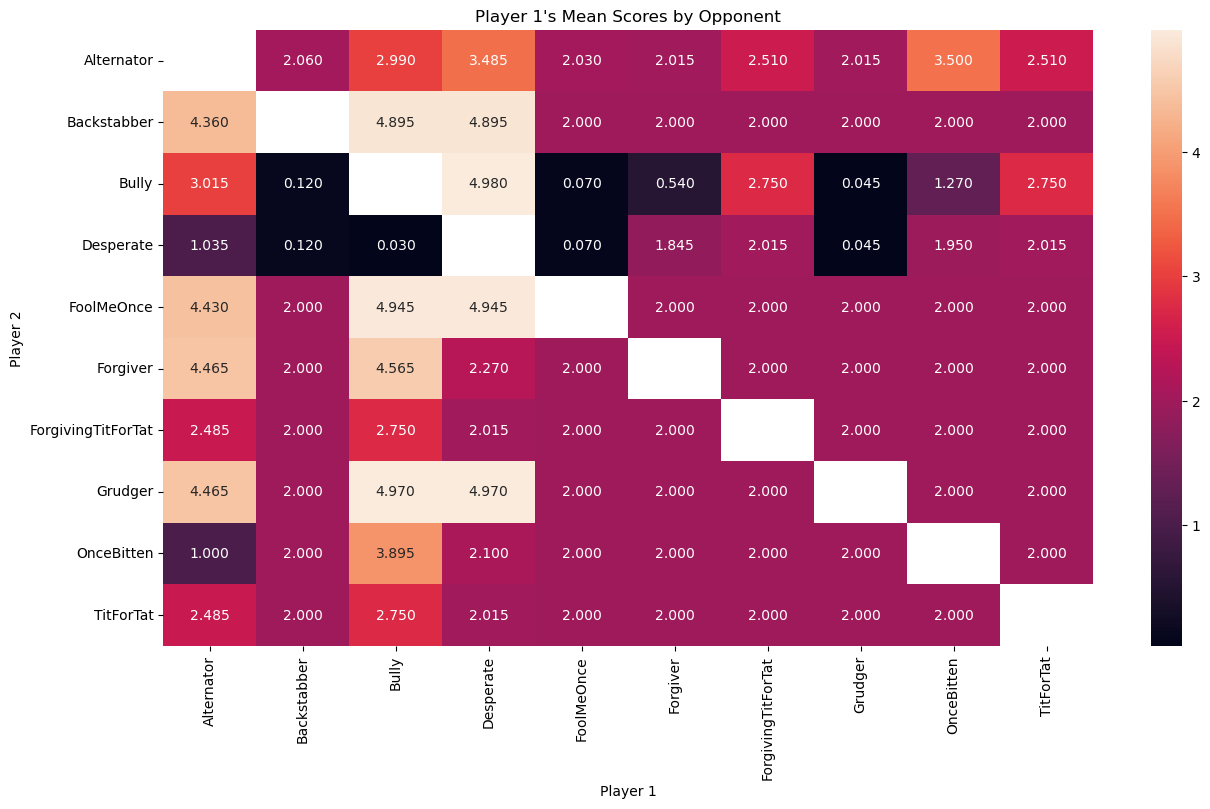

In [24]:
df1 = tournament_results.to_df()
df2 = tournament_results.to_df()
df2 = df2.rename({"p1": "p2", "p2": "p1", "p1_mean": "p2_mean", "p2_mean": "p1_mean"}, axis=1)
df = pd.concat([df1, df2])
df["p1"], df["p2"] = df["p1"].astype(str), df["p2"].astype(str)
df = df.pivot(index="p1", columns="p2", values="p1_mean")

plt.figure(figsize=[15,8])
sns.heatmap(df.T, annot=True, fmt=".3f")
plt.xlabel("Player 1")
plt.ylabel("Player 2")
plt.title("Player 1's Mean Scores by Opponent")
plt.xticks(rotation=90);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1.10:** Interpret the plot above. What results stand out to you? Which strategy would you choose if you were playing in a tournament? Justify your answer.


Based on the plot, Bully and Desperate seem to have high chances of winning, which is out of the ordinary. Alternator seems to do quite well against most of the agressive playersAnd TitForTat seems to have the most balanced strategy but it does seem to also have the lowest chances of winnings compared to the rest of the strategies. I would choose to play desperate because it has a very consistent above the mean score i.e. winning compared to the rest of the strategies. 

<!-- END QUESTION -->

Now that we have the experience of creating prisoner's dilemma tournaments, let's consider Axelrod's findings. The [winning deterministic strategy](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma#Strategy_for_the_iterated_prisoner's_dilemma) was, surprisingly, tit-for-tat. This strategy was entered into the competition by [Anatol Rapoport](https://en.wikipedia.org/wiki/Anatol_Rapoport), coded in only four lines of BASIC. Axelrod studied the best strategies and came up with the following four traits of the biggest winners: niceness, retaliation, forgiveness, and lack of envy.

<!-- BEGIN QUESTION -->

**Question 1.11:** In analyzing his tournament, Axelrod noted that one of the traits of the best strategies was being "non-envious." A strategy that is non-envious does not strive to score higher than its opponent. Why do you think this trait is linked to good strategies? How does one of the other strategies you looked at (excluding defector, cooperator, and tit-for-tat) embody this trait?


non-evious strategies stop players from making rash decisions which would allow us to play different moves as well. Especially when looking at the alternator startegies where we alternate between strategies, we are not striving to score higher than the oppoenent; we are simply alternating our strategies which is playing not on emotion so they are not-envious. Tit-for-tat is also non-envious and it tends to do average and it defends well against all strategies which might be beneficial in certain situations where a balanced strategy is needed. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1.12:** The prisoner's dilemma is often used by economists to study and understand different phenomena that are observed in economies at different scales (e.g. studying oligopolies). Another common economic application is studying advertising and how the advertising of other firms needs to be taken into account in a single firm's advertising strategies. Describe how firms in an advertising space can be viewed as players in an iterated prisoner's dilemma. What decisions are analogous to defection and cooperation? What are the payoffs of each?


Firms in an advertising space can be viewed as players in an iterated prisoner's dilemma where each player is the firm, and each firm has two choices: 
1. Deflection (both firms advertise): When a firm chooses to advertise aggressively, it is analogous to defecting in the prisoner's dilemma. By doing so, the firm aims to capture a larger market share at the expense of its competitor, even though this incurs high advertising costs.
2. Cooperation (No Advertising): When a firm decides to either not advertise or keep advertising to a minimum, it’s akin to cooperation. Both firms would benefit from saving on advertising costs while maintaining a stable market share.

The payoffs of each are as follows:
1. Both Firms Advertise (Mutual Defection): If both firms choose to advertise they both have high costs. The increased spending would mean a low payoff for both, as the high advertising costs would cancel any of the revenue gains so that the marketshare would barely change.
2. Neither Firm Advertises (Mutual Cooperation): If both don't advertise they can avoid high costs and retain stable profits. This situation is mutually beneficial and represents a higher payoff for both firms.
3. One Firm Advertises, the Other Does Not: If one firm advertises while the other does not, the firm that advertises will gains an advantage, capturing a larger market share and increasing its payoff at the expense of the non-advertising firm. The advertising firm achieves a high payoff, while the non-advertising firm receives a low payoff, as it loses market share.

<!-- END QUESTION -->

If you want to learn more about this tournament, there's a very interesting [episode of Radiolab](https://www.wnycstudios.org/podcasts/radiolab/segments/104010-one-good-deed-deserves-another) that describes the origins of Axelrod's tournament, the iterated prisoner's dilemma, and the tit-for-tat strategy.

## Part 2: Height Perceptions

For the rest of this project, we are going to move on to replicating the analysis in [this paper](https://doi.org/10.3389/fpsyg.2015.00306) by Thomas and Pemstein (2015). The paper describes two experiments, both of which we will cover in this project. **Before doing this part,** you may want to refresh your memory on A/B testing and p-values by rereading [Chapters 11 and 12 of the Data 8 Textbook](https://www.inferentialthinking.com/chapters/11/Testing_Hypotheses.html).

<div class="alert alert-warning">
    
Take a moment to read the <a href="https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00306/full#h3" target="_blank">Experiment 1 methodology</a> from the paper. Ensure you understand the experiment before moving on.

</div>

**Question 2.1:** The first experiment examined subjects' perception of height by adjusting the

<ol type="A" style="list-style-type: lower-alpha;">
    <li>screen position</li>
    <li>camera position</li>
    <li>camera focus</li>
    <li>camera exposure</li>
</ol>

Assign the letter corresponding to your answer to `q2_1` below.


In [25]:
q2_1 = "b"

In [26]:
grader.check("q2_1")

q2_1 results: All test cases passed!

Now we'll read in the experimental data from the paper. The table below gives the condition, height estimate, and true height for each subject. Recall that individuals can be in one of two conditions: "down", where they're looking up at the pictured individual, and "up", where they're looking down at the pictured individual.

In [27]:
exp1_raw = Table.read_table("frontiers1.csv")
exp1_raw

Estimate,Condition,Picture,TrueHeight
72,down,d,71
72,down,d,71
74,down,d,71
72,down,d,71
71,down,d,71
68,down,d,71
69,down,d,71
67,down,d,71
74,down,d,71
72,down,d,71


In this section, we will be conducting an A/B test, wherein we split some data into two groups randomly and calculate some test statistic on each group. The first component of an A/B test is a **test statistic**, a value that we calculate that compares two groups. A good test statistic is one for which large or small values _but not both_ indicate in the direction of the alternative hypothesis.

As a **precursor** to our test statistic (i.e. not as the test statistic itself), we will calculate the error ratio between the estimate and the true height:

$$\Large
\frac{\text{estimate} - \text{true height}}{\text{true height}}
$$

This will give us the magnitude of the difference relative to the true height, to correct for any scale differences based on the actual height of the figure, and whether the estimate was above or below the actual height.

**Question 2.2:** How can we turn the error ratio column into a good test statistic for comparing the two conditions?

<ol type="A" style="list-style-type: lower-alpha;">
    <li>take the signed difference of the standard deviation of the error ratios for both groups</li>
    <li>take the absolute difference of the standard deviation of the error ratios for both groups</li>
    <li>take the signed difference of the mean error ratios for both groups</li>
    <li>take the absolute difference of the mean error ratios for both groups</li>
</ol>

Assign the letter corresponding to your answer to `q2_1` below.


In [28]:
q2_2 = "d"

In [29]:
grader.check("q2_2")

q2_2 results: All test cases passed!

**Question 2.3:** Add an `ErrorRatio` column to `exp1_raw` with the error ratio using the formula above. Store the resulting table as `exp1`.


In [30]:
error_ratio = (exp1_raw.column("Estimate") - exp1_raw.column("TrueHeight")) / exp1_raw.column("TrueHeight")
exp1 = exp1_raw.with_column("ErrorRatio", error_ratio)
exp1

Estimate,Condition,Picture,TrueHeight,ErrorRatio
72,down,d,71,0.0140845
72,down,d,71,0.0140845
74,down,d,71,0.0422535
72,down,d,71,0.0140845
71,down,d,71,0
68,down,d,71,-0.0422535
69,down,d,71,-0.028169
67,down,d,71,-0.056338
74,down,d,71,0.0422535
72,down,d,71,0.0140845


In [31]:
grader.check("q2_3")

q2_3 results: All test cases passed!

Now that we have quantified the error of each estimate, let's take a look at the distributions of these values in order to develop some intuition before we generate our alternative hypothesis.

<!-- BEGIN QUESTION -->

**Question 2.4:** Plot overlaid histograms of the `ErrorRatio` column grouped by `Condition`. 

_Hint:_ Recall that we can created a grouped histogram of a column of a table using `tbl.hist(..., group=GROUP_COLUMN)`.


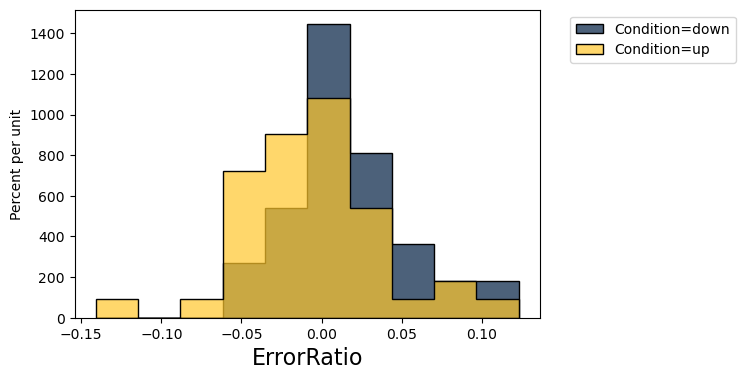

In [32]:
exp1.hist('ErrorRatio', group='Condition')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.5:** Interpret the histogram you just created. What can you say about the distributions of the up- and down-conditions?

_Hint:_ Look at where each histogram is centered.


The center of both histograms seems to be centered around 0 and theres is no higher or lower central tendency between both which may indicate that there is no significant difference in the error ratios between the conditions. Observing the spread, the up condition seems to be more spread out and has more data points in left hand side and as such look to have a lower mean, and the down condition seems to have a higher mean since more data is on the right hand side. 

<!-- END QUESTION -->

Now that we know how we can quantify the difference between the estimate and true height and we have some idea of their distributions, how can we determine if the differences between the two are drawn from different distributions based on the condition?

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.6:** What are the null and alternative hypotheses for our A/B test?


**Null hypothesis:** No difference between the perception of heights depending on how the camera is positioned.

**Alternative hypothesis:** There is difference between the perception of heights depending on how the camera is positioned.

<!-- END QUESTION -->

<!-- END QUESTION -->

Before we get into performing the A/B test, we need to create a way for us to easily calculate the error ratios for each iteration.

**Question 2.7:** Fill in the function `add_error_ratio` which will take in a table, create the `ErrorRatio` column as above, and return a new table.


In [33]:
def add_error_ratio(tbl):
    """Adds error ratio column to tbl"""
    error_ratio = (tbl.column("Estimate") - tbl.column("TrueHeight")) / tbl.column("TrueHeight")
    tbl = tbl.with_column("ErrorRatio", error_ratio)
    return tbl

In [34]:
grader.check("q2_7")

q2_7 results: All test cases passed!

In order to run an A/B test, we need to choose a test statistic. Recall that a good test statistic indicates in the direction of the alternative hypothesis at very high or very low values. In this case, we will use the mean error ratio for each group, which indicates the alternative at higher values. 

The function `calc_abs_diff_mean_error_ratio` defined below will calculate the error ratios, compute the mean for each group, and return the absolute difference between the two. *Note that it requires your `add_error_ratio` function to work correctly.*

In [35]:
def calc_abs_diff_mean_error_ratio(tbl):
    """Calculates absolute difference between mean error ratios"""
    tbl = add_error_ratio(tbl)
    grouped = tbl.group("Condition", np.mean)
    return abs(grouped.column("ErrorRatio mean").item(0) - grouped.column("ErrorRatio mean").item(1))

OK, now we have all the pieces we need to perform an A/B test. Recall that in the general outline of an A/B test, we

1. shuffle the condition we're examining several times
2. calculate the test statistic on each of the shuffled conditions
3. collect these statistic values somewhere
4. compute the observed value of the test statistic (i.e. the test statistic on the original data)
5. compute the p-value as the proportion of values further in the direction of the alternative hypothesis than the observed value

An outline for the code of this process might be:

```python
test_statistics = make_array()
for i in range(n):
    shuffled_conditions = # shuffle the table and grab conditions
    shuffled_table = # replace condition column with shuffled_conditions
    test_statistic = # value of test statistic on shuffled conditions
    test_statistics = # append test_statistic to test_statistics
    
observed_value = # value of test statistic on original data
p_value = # proportion of test_statistics <=/>= observed_value
```

**Question 2.8:** In the cell below, fill in the code to run the A/B test on our data and collect the test statistic values in `ratio_diffs`. Recall that to run an A/B test we need to shuffle the values of the `Condition` column, drop the original column, and add in the new values.


In [43]:
ratio_diffs = make_array()

for i in np.arange(1000):
    conditions = exp1.sample(with_replacement = False)['Condition']
    shuffled_exp1 = exp1.drop('Condition').with_column('Condition', conditions)
    ratio_diffs = np.append(ratio_diffs, calc_abs_diff_mean_error_ratio(shuffled_exp1))
    
ratio_diffs[:5]

array([ 0.00280658,  0.00725378,  0.01652995,  0.01043182,  0.00341536])

In [44]:
grader.check("q2_8")

q2_8 results: All test cases passed!

To determine the results of our A/B test, we need to calculate a p-value. To calculate the p-value, we find the percentage of results wherein the test statistic was *further in the direction of the alternative hypothesis* than the observed value.

**Question 2.9:** Calculate the observed value of the test statistic using the `calc_abs_diff_mean_error_ratio` function and store it as `observed_value`. Then calculate the p-value and store it as `p_value`.

_Hint:_ Do values **above** or **below** `observed_value` indicate the alternative hypothesis?


In [45]:
observed_value =  calc_abs_diff_mean_error_ratio(exp1)
p_value = np.mean(ratio_diffs >= observed_value)
p_value

0.012

In [39]:
grader.check("q2_9")

q2_9 results: All test cases passed!

**Question 2.10:** Using the conventional p-value cutoff of 0.05, which hypothesis do we adopt?

<ol style="list-style-type: lower-alpha;">
    <li>null hypothesis</li>
    <li> alternative hypothesis</li>
</ol>


In [67]:
q2_10 = "b"

In [68]:
grader.check("q2_10")

q2_10 results: All test cases passed!

## Part 3: Height Perceptions and the Game

In this section of the project, we will look at the second experiment from Thomas and Pemstein (2015). In this experiment, the placement of cameras is used to determine what effect the perception of height has on the leader-follower behavior of subjects.

<div class="alert alert-warning">
    
Take a moment to read the <a href="https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00306/full#h4" target="_blank">Experiment 2 methodology</a> from the paper. Ensure you understand the experiment before moving on.

</div>

The payoff structure of the game is reproduced below for your reference.

<img src="exp2-payoffs.jpg" width="600px" alt="Payoff Structure" />

**Note:** In the rest of this project, <img src="chainmail.png" style="display: inline-block; vertical-align: text-bottom;" width="30px"/> will be referred to as the "chainmail pattern" and <img src="bricks.png" style="display: inline-block; vertical-align: text-bottom;" width="30px"/> as the "brick pattern."

**Question 3.1:** If Player 1 chooses the chainmail pattern and Player 2 the brick pattern, what is the payoff for each player?

<ol type="A" style="list-style-type: lower-alpha;">
    <li>1: \$0, 2: \$2</li>
    <li>1: \$2, 2: \$3</li>
    <li>1: \$3, 2: \$2</li>
    <li>1: \$0, 2: \$0</li>
</ol>

Assign the letter corresponding to your answer to `q3_1` below.


In [50]:
q3_1 = "d"

In [51]:
grader.check("q3_1")

q3_1 results: All test cases passed!

**Question 3.2:** What is meant by the "asymmetrical condition" in the paper?

<ol type="A" style="list-style-type: lower-alpha;">
    <li>cameras are placed on different sides (left/right) of the monitor</li>
    <li>one camera is up or down and the other is in the center of the monitor</li>
    <li>one camera is up and the other is down</li>
    <li>both cameras are on the same side of the monitor (both up or both down)</li>
</ol>

Assign the letter corresponding to your answer to `q3_2` below.


In [52]:
q3_2 = "c"

In [53]:
grader.check("q3_2")

q3_2 results: All test cases passed!

Now we'll read in the data from the experiment. The `Condition` column here indicates whether the subjects are in the asymmetrical (`1`) or symmetrical (`2`) condition. The `Choice` column indicates their choice of payoff (for themselves) and the `Winnings` column what they actually won.

In [54]:
exp2 = Table.read_table("frontiers2.csv") 
exp2

Number,Room,Pattern,Choice,Winnings,Condition
1,up,A,3,3,1
2,down,A,2,2,1
5,down,B,2,2,1
6,up,B,3,3,1
7,up,A,2,2,1
8,down,A,3,3,1
9,up,B,2,2,1
10,down,B,3,3,1
11,up,B,2,2,1
12,down,B,3,3,1


<!-- END QUESTION -->

In order to determine whether the camera placement had an effect on the payoff choice in the experimental condition, we need to check that people in the one condition chose the payoff-maximizing choice more often that people in the other condition. Let's start by limiting the data to subjects in the experimental condition and creating a variable that indicates whether the subject chose the payoff-maximizing value.

**Question 3.3:** Filter `exp2` for rows in the experimental condition (`Condition` is 1) and store this as `exp_condition`. Then add a column to `exp_condition` that indicates whether the subject chose the payoff-maximizing value by applying the provided `payoff_maximizing` function to the `Choice` column; store this as the `Payoff` column.


In [55]:
def payoff_maximizing(val):
    return int(val == 3)

exp_condition = exp2.where("Condition", 1)
payoffs = exp_condition.apply(payoff_maximizing, "Choice")
exp_condition = exp_condition.with_column("Payoff", payoffs)
exp_condition

Number,Room,Pattern,Choice,Winnings,Condition,Payoff
1,up,A,3,3,1,1
2,down,A,2,2,1,0
5,down,B,2,2,1,0
6,up,B,3,3,1,1
7,up,A,2,2,1,0
8,down,A,3,3,1,1
9,up,B,2,2,1,0
10,down,B,3,3,1,1
11,up,B,2,2,1,0
12,down,B,3,3,1,1


In [56]:
grader.check("q3_3")

q3_3 results: All test cases passed!

Now that we know which subjects chose the payoff-maximizing value, we can run an A/B test on this variable to determine whether the `Room` variable (which indicates whether the camera was up or down) has any effect on the outcome. We'll use the absolute difference between the proportion of 1's in each group as our test statistic. The provided function `payoff_proportion` will calculate this value when provided an array of `Payoff` values.

In [57]:
def payoff_proportion(payoffs):
    return np.sum(payoffs) / len(payoffs)

payoff_proportion(make_array(0, 1, 0, 1))

0.5

Now that we know how to calculate the test statistic, let's think about how we can group our table for the A/B test. We'll need to group on the `Room` variable, and we can use our `payoff_proportion` function as the collection function for `Table.group`.

In [58]:
grouped_exp = exp_condition.group("Room", payoff_proportion)
grouped_exp

Room,Number payoff_proportion,Pattern payoff_proportion,Choice payoff_proportion,Winnings payoff_proportion,Condition payoff_proportion,Payoff payoff_proportion
down,,,2.66667,2.28571,1,0.666667
up,,,2.38095,2,1,0.380952


Now that we have the grouped values, we can calculate our test statistic by taking the absolute difference of the two values.

In [59]:
payoff_props = grouped_exp.column("Payoff payoff_proportion")
abs(payoff_props.item(0) - payoff_props.item(1))

0.2857142857142857

With the logic for how we calculate the test statistic value in place, let's write a function that will do this for us in each loop of the A/B test.

**Question 3.4:** Fill in the function `calc_condition_test_stat` below which runs through the logic above for a provided table `tbl`.

_Hint:_ You can check that your function is correct by comparing the cell's output to the last code cell.


In [60]:
def calc_condition_test_stat(tbl):
    grouped_exp = tbl.group("Room", payoff_proportion)
    payoff_props = grouped_exp.column("Payoff payoff_proportion")
    return np.abs(payoff_props.item(0) - payoff_props.item(1))

calc_condition_test_stat(exp_condition)

0.2857142857142857

In [61]:
grader.check("q3_4")

q3_4 results: All test cases passed!

Now that we have an easy way to calculate the test statistic, let's build our A/B test. Recall that we will need to shuffle the values of the `Room` variable and then run `calc_condition_test_stat` on the resulting table.

**Question 3.5:** Fill in the code below to run the A/B test and collect our test statistic values in `condition_stat_values`.


In [62]:
condition_stat_values = make_array()
for i in np.arange(1000):
    conditions = exp_condition.sample(with_replacement = False)['Room']
    shuffled_exp_condition = exp_condition.drop('Room').with_column('Room', conditions)
    stat_value = calc_condition_test_stat(shuffled_exp_condition)
    condition_stat_values = np.append(condition_stat_values, stat_value)
    
condition_stat_values[0:5]

array([ 0.0952381 ,  0.        ,  0.04761905,  0.28571429,  0.04761905])

In [63]:
grader.check("q3_5")

q3_5 results: All test cases passed!

Now let's calculate our p-value. As with before, values *higher* than the observed value indicate the alternative hypothesis, so we'll be looking for those again.

**Question 3.6:** Fill in the code below to store the observed value as `condition_observed_value` and the p-value as `condition_p_value`.


In [64]:
condition_observed_value = calc_condition_test_stat(exp_condition)
condition_p_value = np.mean(condition_stat_values >= condition_observed_value)
condition_p_value

0.02

In [65]:
grader.check("q3_6")

q3_6 results: All test cases passed!



**Question 3.7:** Using the conventional p-value cutoff of 0.05, which hypothesis do we adopt?

<ol style="list-style-type: lower-alpha;">
    <li>null hypothesis</li>
    <li> alternative hypothesis</li>
</ol>


In [76]:
q3_7 = "a"

In [77]:
grader.check("q3_7")

q3_7 results: All test cases passed!


---

**References:** 

Thomas, L. E., & D. Pemstein (2015). "What you see is what you get: webcam placement influences perception and social coordination." _Frontiers in Psychology._ https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00306/full

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [69]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q1_6 results: All test cases passed!

    q1_7 results: All test cases passed!

    q1_8 results: All test cases passed!

    q1_9 results: All test cases passed!

    q2_1 results: All test cases passed!

    q2_2 results: All test cases passed!

    q2_3 results: All test cases passed!

    q2_7 results: All test cases passed!

    q2_8 results: All test cases passed!

    q2_9 results: All test cases passed!

    q2_10 results: All test cases passed!

    q3_1 results: All test cases passed!

    q3_2 results: All test cases passed!

    q3_3 results: All test cases passed!

    q3_4 results: All test cases passed!

    q3_5 results: All test cases passed!

    q3_6 results: All test cases passed!

    q3_7 results: All test cases passed!
